# From here it's working 

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
df = pd.read_csv('dataset_timeseries_training.csv')  

In [3]:
df.head()

Date       Open       High        Low      Close  Adj Close    Volume
0  01-06-2015  26.839500  26.839500  26.488001  26.699499  26.699499  38086000
1  02-06-2015  26.646500  27.150000  26.566500  26.959000  26.959000  38780000
2  03-06-2015  26.995501  27.174999  26.855499  27.015499  27.015499  34340000
3  04-06-2015  26.888000  27.029499  26.716000  26.834999  26.834999  26966000
4  05-06-2015  26.817499  26.860001  26.625999  26.666500  26.666500  27764000

# Data scaling

In [4]:
# Prepare the data
data = df.filter(['Open']).values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


# Splitting 

In [5]:

# Split the data into training and testing sets
train_data = scaled_data[:int(len(data) * 0.8)]
test_data = scaled_data[int(len(data) * 0.8):]
print(test_data.shape)
train_data.shape

(255, 1)


(1019, 1)

# Sequence generation

In [6]:

# Function to create the dataset
def create_dataset(dataset, time_steps):
    X, y = [], []a
    
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:i + time_steps,0])
        y.append(dataset[i + time_steps,0])
    return np.array(X), np.array(y)

time_steps = 60  # Number of previous time steps to use for prediction


In [7]:

# Create the training and testing datasets
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

print("X_train shape",X_train.shape)
print("y_train shape",y_train.shape)

print("x_test shape",X_test.shape)
print("y_test shape",y_test.shape)

X_train shape (959, 60)
y_train shape (959,)
x_test shape (195, 60)
y_test shape (195,)


# Reshape so that it's compatable with lstm

In [8]:
# Reshape the input data for the LSTM model [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))




print("X_train shape",X_train.shape)
print("x_test shape",X_test.shape)
X_train

X_train shape (959, 60, 1)
x_test shape (195, 60, 1)


array([[[0.01719423],
        [0.01335561],
        [0.02029697],
        ...,
        [0.13520687],
        [0.11961375],
        [0.05320365]],

       [[0.01335561],
        [0.02029697],
        [0.01815885],
        ...,
        [0.11961375],
        [0.05320365],
        [0.09488153]],

       [[0.02029697],
        [0.01815885],
        [0.01675664],
        ...,
        [0.05320365],
        [0.09488153],
        [0.09034676]],

       ...,

       [[0.66560253],
        [0.67409526],
        [0.69264194],
        ...,
        [0.55041413],
        [0.57129787],
        [0.5554064 ]],

       [[0.67409526],
        [0.69264194],
        [0.70290483],
        ...,
        [0.57129787],
        [0.5554064 ],
        [0.5610151 ]],

       [[0.69264194],
        [0.70290483],
        [0.67367759],
        ...,
        [0.5554064 ],
        [0.5610151 ],
        [0.5637797 ]]])

# Model building with LSTM

In [9]:
from tensorflow.keras.layers import RepeatVector
# Build the LSTM model

model = Sequential()

model.add(LSTM(units=60,input_shape=(X_train.shape[1],X_train.shape[2]),activation='tanh'))

model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(units=50,activation='tanh'))
model.add(Dense(units=25,activation='tanh'))
model.add(Dense(units=1))


In [10]:

# Compile and train the model
model.compile(optimizer='adam', loss='mean_absolute_error')


In [11]:
X_train.shape

(959, 60, 1)

In [12]:
model.fit(X_train, y_train, batch_size=32, epochs=25)

Epoch 1/25
30/30 [==============================] - 10s 77ms/step - loss: 0.0870
Epoch 2/25
30/30 [==============================] - 2s 77ms/step - loss: 0.0185
Epoch 3/25
30/30 [==============================] - 2s 77ms/step - loss: 0.0169
Epoch 4/25
30/30 [==============================] - 2s 77ms/step - loss: 0.0168
Epoch 5/25
30/30 [==============================] - 2s 75ms/step - loss: 0.0173
Epoch 6/25
30/30 [==============================] - 2s 76ms/step - loss: 0.0153
Epoch 7/25
30/30 [==============================] - 2s 75ms/step - loss: 0.0152
Epoch 8/25
30/30 [==============================] - 2s 74ms/step - loss: 0.0196
Epoch 9/25
30/30 [==============================] - 2s 73ms/step - loss: 0.0161
Epoch 10/25
30/30 [==============================] - 2s 76ms/step - loss: 0.0151
Epoch 11/25
30/30 [==============================] - 2s 76ms/step - loss: 0.0152
Epoch 12/25
30/30 [==============================] - 2s 73ms/step - loss: 0.0137
Epoch 13/25
30/30 [=================

# Visualization

In [13]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions
#train_predictions = scaler.inverse_transform(train_predictions)
#test_predictions = scaler.inverse_transform(test_predictions)

# Calculate the root mean squared error (RMSE)
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(y_train,train_predictions)
mae_test=mean_absolute_error(y_test,test_predictions)



# Print the RMSE
print("Train mae:", mae_train)
print("Test mae:", mae_test)

7/7 [==============================] - 0s 27ms/step
Train mae: 0.013343353969440466
Test mae: 0.018210547208365353


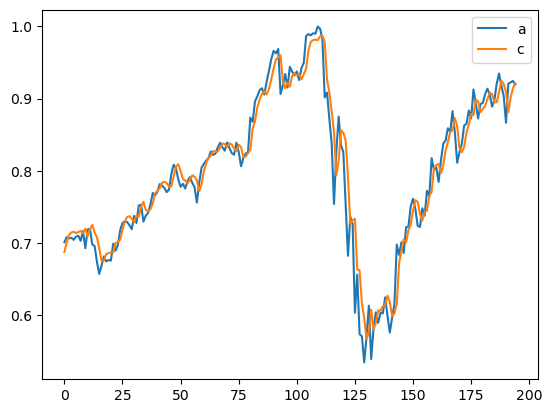

In [14]:
import matplotlib.pyplot as plt

plt.plot(y_test)
plt.plot(test_predictions)
plt.legend('actual')


# Visualization with 7 days break

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


length of data list 195
length of actual data after flatten and list 195
shape of reshaped_data 28
shape of reshaped_data 28


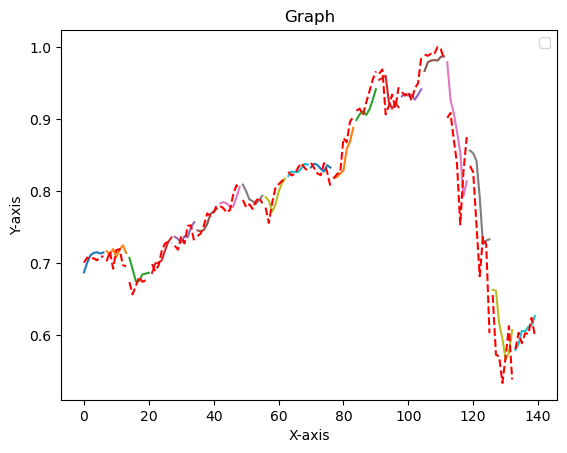

In [16]:
predict_flatten=test_predictions.flatten()
data = predict_flatten.tolist()  
print("length of data list",len(data))

# Flatten and convert actual values to a list
actual_flatten = y_test.flatten()
actual_data = actual_flatten.tolist()
print("length of actual data after flatten and list",len(actual_data))

# Reshape the data to have 7 columnsa

reshaped_data = [data[i:i+7] for i in range(0, len(data), 7)]
print("shape of reshaped_data",len(reshaped_data))

# Create the plot
fig, ax = plt.subplots()
for i, row in enumerate(reshaped_data[:20]): 
    x= range(i*7, (i+1)*7)
    ax.plot(x, row)

reshaped_data2 = [actual_data[i:i+7] for i in range(0, len(actual_data), 7)]
print("shape of reshaped_data",len(reshaped_data2))

for j, col in enumerate(reshaped_data2[:20]): 
    y = range(j*7, (j+1)*7)
    ax.plot(y, col,linestyle='--', color='red')

# Plot each row of data (actual values)
#plt.plot(y_test[: :5])
# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Graph')
ax.legend()
plt.show()